In [2]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.io import loadmat
from scipy.optimize import fmin_cg

# Exercise 4.1: Neural Network (dimension-400, power-1, category-10, regularised)
---

We finish exercise-3 by looking at a 2-layer neural network classifier, using a set of parameters trained on MNIST handrwitten digits. The same task is achieved in the beginning of exercise-3 via a one-versus-all logistic regression classifier, essentially a stack of binary logistic regression classifiers, but the neural network accuracy was seen to be much higher. The neural network approach is powerful as it not only learns the parameters required to map a set of input features into a set of output categories, but it also learns how best to mix the given features into intermediate sets of features, with multiple such mixing stages possible, allowing for great versatility that goes beyond what the programmer may have in mind in terms of what features could be useful.

In this exercise we visit the same problem again, and actually go ahead and train the neural network weights ourselves. The seed of the logistic regression approach will be apparent throughout. Let's start by reminding ourselves of the input data:

In [3]:
d1 = loadmat('ex4/ex4data1.mat')
d1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [71]:
d1_X = d1['X']
d1_X.shape

(5000, 400)

In [72]:
d1_y = d1['y']
d1_y.shape

(5000, 1)

In [73]:
del(d1)

In [12]:
plt.gray() # I think this sets output to greyscale for all plots from now on

<Figure size 432x288 with 0 Axes>

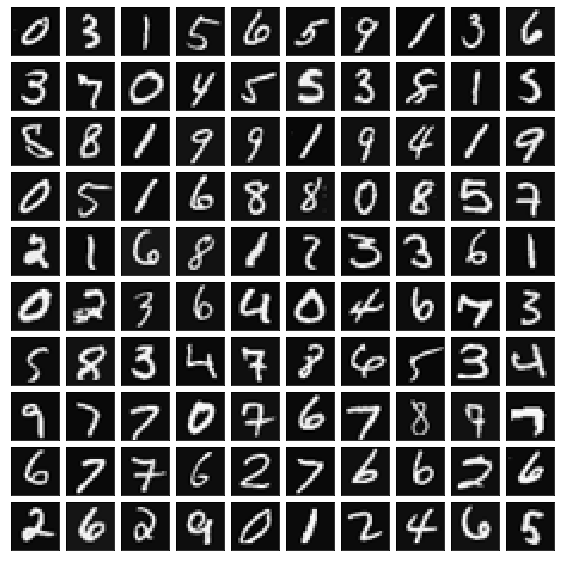

In [13]:
fig = plt.figure(figsize=(10,10))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (10,10),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_X[exs_idx], [20,20]))
    for exs_idx in np.random.choice(d1_X.shape[0], 100, replace=False)
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

---

We also have some pre-trained parameters to just check out and use for testing the cost function that we define later on, but which otherwise aren't needed for the real task in hand of training the network ourselves. We are using a 2-layer network, which is an arbitrary choice of layers, but the simplest to just understand neural network principles. The parameters of each layer are stored as separate arrays.

The array of the first layer of parameters is as large in one index as the number of input features of the raw data, as dictated by the programmer (i.e. we could, if we wanted to, specify various powers and mixings of the simplest power-1 features ourselves, we don't have to leave all mixing decisions entirely up to the network), and as large in the other index as however many intermediate features we want output from that layer. This is completely arbitrary, more is typically better (up to a limit???), but comes with a processing cost.

The array of the second layer of parameters is as large in one index as the number of output features from the first layer, and as large in the other index as however many final output options we want. Typically this will be one option for each of a number of categories.

For the case in hand, we are not defining further input features beyond the raw power-1 features, with each being the greyscale value of a given image pixel, 400 in total from our 20 $\times$ 20 pixel images (plus a further one for a dummy offset feature). So that dictates one index of the first layer parameter array. The other index is 25 elements long, as we allow the network to determine 25 mixings of the input features. As those input features are just the raw power-1 input pixel information, each of the 25 mixings can be thought of as an image "filter", and they can be rolled up into some kind of image themselves. Each of those 25 filtered images is then taken by the second layer of the array, and combined in 10 different ways to produce 10 different output sigmoid values for a given input image, one for each digit category it could be. Each of these 10 mixings can also be seen as a "filter" of the intermediate images, and they can also be rolled up into images of their own. Let's do that for both layers to get some visual understanding of what we have, and of what we will train:

In [9]:
d1_thetas_nn = loadmat('ex4/ex4weights.mat')
d1_thetas_nn.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [7]:
d1_thetas_nn['Theta1'].shape

(25, 401)

In [47]:
d1_thetas_nn['Theta1'] = np.transpose(d1_thetas_nn['Theta1'])
d1_thetas_nn['Theta1'].shape

(401, 25)

In [8]:
d1_thetas_nn['Theta2'].shape

(10, 26)

In [48]:
d1_thetas_nn['Theta2'] = np.transpose(d1_thetas_nn['Theta2'])
d1_thetas_nn['Theta2'].shape

(26, 10)

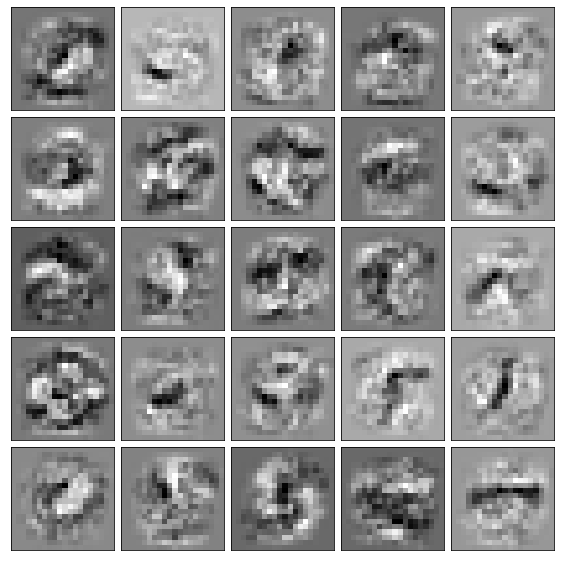

In [50]:
fig = plt.figure(figsize=(10,10))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (5,5),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_thetas_nn['Theta1'][1:,nodes_idx], [20,20]))
    for nodes_idx in range(d1_thetas_nn['Theta1'].shape[1])
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

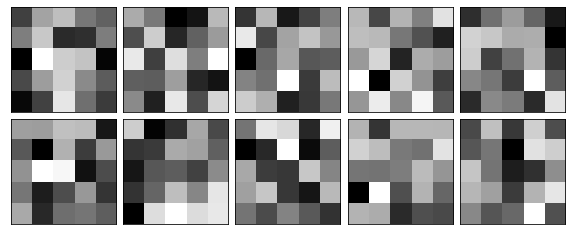

In [51]:
fig = plt.figure(figsize=(10,4))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (2,5),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_thetas_nn['Theta2'][1:,nodes_idx], [5,5]))
    for nodes_idx in range(d1_thetas_nn['Theta2'].shape[1])
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

Pretty funky looking.

---

Let's make a function to include an offset term via the dummy feature $x_0 = 1$:

In [22]:
def add_ones(X):
    return(np.append(np.ones([X.shape[0],1]), X, axis=1))

In [23]:
d1_X_ones = add_ones(d1_X)
d1_X_ones.shape

(5000, 401)

---

Now define the sigmoid function and the cost function and test. Note that the sigmoid gradient function is needed for the cost derivative, but this is not used in actual training later on, as we again defer to the automated optimiser function. Also observe that the calculations for each network layer are the same as seen before in the logistic regression classifier. Rather than individually training separate binary classifiers, as we did with the one-versus-all logistic regression classifier in exercise-3, this approach trains all output channels simulateously, meaning that we must first convert the known data labels to a one-hot-encoded form:

In [25]:
d1_y_onehot = np.zeros([d1_y.shape[0], d1_thetas_nn['Theta2'].shape[0]])

for exs_idx in range(d1_y.shape[0]):
    cats_idx_ex = d1_y[exs_idx] - 1
    d1_y_onehot[exs_idx][cats_idx_ex] = 1

In [26]:
def sigmoid(g):
    return(1 / (1 + np.exp(-g)))

In [27]:
def sigmoid_grad(g):
    return(sigmoid(g) * (1-sigmoid(g)))

In [34]:
# Regarding Andrew's indices in the exercise notes (but not used in the code here):
#   i index of example
#   t index of example (dunno why Andrew also indexed this as t despite using i several times before t was seen ...)
#   j index of layer output node (either layer, Andrew has used the same letter for both ...)
#   k index of layer input node (either layer, Andrew has used the same letter for both ... actually, k has also been used as output node index too ...)
#   l index of layer of weights

def get_cost(
    theta,
    theta1_shape,
    theta2_shape,
    lamb,
    X_ones,
    y_onehot,
    get_derivative=True,
):

    theta1_len = np.product(theta1_shape)
    theta1 = theta[0:theta1_len].reshape(theta1_shape)
    theta2 = theta[theta1_len:].reshape(theta2_shape)

    m = X_ones.shape[0]          # 5000 rows
    g1 = np.dot(X_ones, theta1)  # 5000 rows, 25 cols
    h1 = sigmoid(g1)             # 5000 rows, 25 cols
    h1_ones = add_ones(h1)       # 5000 rows, 26 cols
    g2 = np.dot(h1_ones, theta2) # 5000 rows, 10 cols
    h2 = sigmoid(g2)             # 5000 rows, 10 cols # These are the predictions for the y_onehot values we're trying to match i.e. h2 is an array of the same size as y_onehot

    cost = \
          (-1 / m) \
        * np.sum((y_onehot * np.log(h2)) + ((1-y_onehot) * np.log(1-h2))) \
        + (lamb / (2 * m)) * (np.sum(np.power(theta1[1:], 2)) + np.sum(np.power(theta2[1:], 2)))

    if (not get_derivative):
        return(cost)
    else:

        # This is the backpropagation procedure for determining the cost derivatives. Note that it's based on the difference between the final output labels and the known labels,
        # just like the logistic regression derivative, but that only provides the derivative for the final layer. For earlier layers we must manipulate those differences some more,
        # hence we "backpropagate" the values:

        d2 = h2 - y_onehot                                             # 5000 rows, 10 cols
        d1 = np.dot(d2, np.transpose(theta2[1:])) * sigmoid_grad(g1)   # 5000 rows, 25 cols

        dcost_by_dtheta1 = (1 / m) * np.dot(np.transpose(X_ones), d1)  # 401 rows, 25 cols
        dcost_by_dtheta2 = (1 / m) * np.dot(np.transpose(h1_ones), d2) # 26 rows, 10 cols

        dcost_by_dtheta1[1:] += (lamb / m) * theta1[1:]
        dcost_by_dtheta2[1:] += (lamb / m) * theta2[1:]

        dcost_by_dtheta = np.append(
            dcost_by_dtheta1.flatten(),
            dcost_by_dtheta2.flatten(),
        )

        return(cost, dcost_by_dtheta)

In [64]:
def get_theta(
    theta_init,
    theta1_shape,
    theta2_shape,
    lamb,
    iters_num,
    X_ones,
    y_onehot,
    disp=True,
):

    theta = fmin_cg(
        get_cost,
        theta_init,
        args=(
            theta1_shape,
            theta2_shape,
            lamb,
            X_ones,
            y_onehot,
            False,
        ),
        maxiter=iters_num,
        disp=disp,
    )

    return(theta)

In [61]:
d1_theta1_shape = d1_thetas_nn['Theta1'].shape
d1_theta2_shape = d1_thetas_nn['Theta2'].shape

In [53]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.append(
        d1_thetas_nn['Theta1'].flatten(),
        d1_thetas_nn['Theta2'].flatten(),
    ),
    d1_theta1_shape,
    d1_theta2_shape,
    0,
    d1_X_ones,
    d1_y_onehot,
)
print(d1_cost)
print(d1_dcost_by_dtheta.shape)
# 0.2876291651613189
# (10285,)

0.2876291651613189
(10285,)


In [54]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.append(
        d1_thetas_nn['Theta1'].flatten(),
        d1_thetas_nn['Theta2'].flatten(),
    ),
    d1_theta1_shape,
    d1_theta2_shape,
    1,
    d1_X_ones,
    d1_y_onehot,
)
print(d1_cost)
print(d1_dcost_by_dtheta.shape)
# 0.38376985909092365
# (10285,)

0.38376985909092365
(10285,)


In [55]:
d1_cost, d1_dcost_by_dtheta = get_cost(
    np.append(
        d1_thetas_nn['Theta1'].flatten(),
        d1_thetas_nn['Theta2'].flatten(),
    ),
    d1_theta1_shape,
    d1_theta2_shape,
    3,
    d1_X_ones,
    d1_y_onehot,
)
print(d1_cost)
print(d1_dcost_by_dtheta.shape)
# 0.5760512469501331
# (10285,)

0.5760512469501331
(10285,)


---

Up until now, we have initialised the parameters as just zeroes. Here we instead intialise the parameters randomly as follows:

In [59]:
def get_theta_init(
    theta_shape,
    epsilon_init,
):
    return((np.random.randint(-1000, 1001, theta_shape) / 1000) * epsilon_init)

In [62]:
d1_epsilon_init = 0.12
d1_theta1_init = get_theta_init(
    d1_theta1_shape,
    d1_epsilon_init,
)
d1_theta2_init = get_theta_init(
    d1_theta2_shape,
    d1_epsilon_init,
)
d1_theta_init = np.append(
    d1_theta1_init.flatten(),
    d1_theta2_init.flatten(),
)
print(d1_theta1_init.shape)
print(d1_theta2_init.shape)
print(d1_theta_init.shape)

(401, 25)
(26, 10)
(10285,)


---

All set, now run the training (takes ~3.5 hours on 2.4 GHz Dual-Core Intel Core i5):

In [65]:
time_start = datetime.now()
d1_theta = get_theta(
    d1_theta_init,
    d1_theta1_shape,
    d1_theta2_shape,
    1,
    50,
    d1_X_ones,
    d1_y_onehot,
)
time_end = datetime.now()

deltat = time_end - time_start
deltat_secs = round(deltat.seconds + (deltat.microseconds / 1e6), 6)
deltat_mins = round(deltat_secs / 60, 6)

print(f'Time taken: {deltat_secs} secs')
print(f'Time taken: {deltat_mins} mins')

         Current function value: 0.451166
         Iterations: 50
         Function evaluations: 1121283
         Gradient evaluations: 109
Time taken: 13297.323008 secs
Time taken: 221.62205 mins


In [66]:
d1_theta1_len = np.product(d1_theta1_shape)
d1_theta1 = d1_theta[0:d1_theta1_len].reshape(d1_theta1_shape)
d1_theta2 = d1_theta[d1_theta1_len:].reshape(d1_theta2_shape)

---

Let's compare all predictions for the given data set itself, and compare with the known labels to get an overall accuracy score:

In [67]:
d1_g1 = np.dot(d1_X_ones, d1_theta1)
d1_h1 = sigmoid(d1_g1)
d1_h1_ones = add_ones(d1_h1)
d1_g2 = np.dot(d1_h1_ones, d1_theta2)
d1_h2 = sigmoid(d1_g2)

d1_predictions = np.transpose([np.argmax(d1_h2, axis=1)])
d1_predictions += 1
d1_accuracy = np.mean(d1_y == d1_predictions)
d1_accuracy
# 0.9598 # Andrew's accuracy is 0.953 ± 0.01, so in agreement

0.9598

---

Finally, let's visualise the parameters of the two layers that we actually trained, just to compare with those of the pre-trained network we saw earlier on:

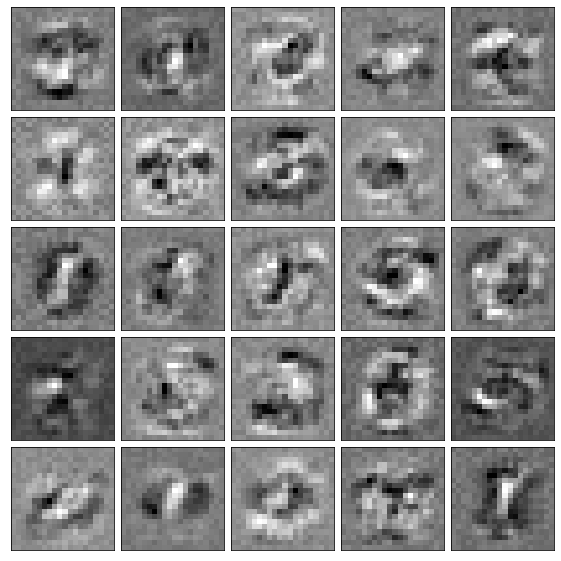

In [68]:
fig = plt.figure(figsize=(10,10))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (5,5),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_theta1[1:,nodes_idx], [20,20]))
    for nodes_idx in range(d1_theta1.shape[1])
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

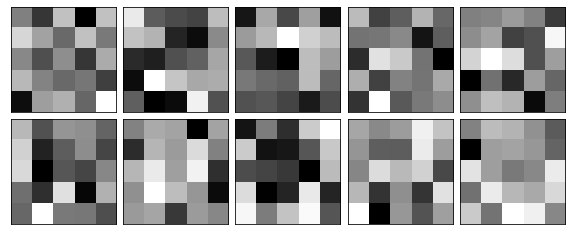

In [69]:
fig = plt.figure(figsize=(10,4))

axs = ImageGrid(
    fig,
    111,
    nrows_ncols = (2,5),
    axes_pad = 0.1,
)

ims = [
    np.transpose(np.reshape(d1_theta2[1:,nodes_idx], [5,5]))
    for nodes_idx in range(d1_theta2.shape[1])
]

for ax,im in zip(axs, ims):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(im)

plt.show()

These are somewhat different from the visualisations of the pre-trained parameters, but the essence of what's going on is still the same, and we can see in the first layer parameters that there's still a tendency to define some centralised circular region with various internal shapes. This circular region is based around the mean position for digits to lie in the input data, and what these parameters are effectively doing is to filter various lines and curves of those input images, essentially "recognising" the components of any one image, and passing those on to the final layer for final assessment.